In [1]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from sklearn.metrics import classification_report
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import cv2

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Python/horse_donkey'

In [4]:
# path of training dataset, used to train the model
train_dir = os.path.join(path, 'dataset/train')
# path of validation dataset, used to validate the model during the training
val_dir = os.path.join(path, 'dataset/validation')
# path of testing dataset, used to evaluate the model after the training
test_dir = os.path.join(path, 'dataset/test')
# path of images for predicting images without labels
pred_dir = os.path.join(path, 'outputs')
# path for saving or loading model
model_path = os.path.join(path, 'checkpoints', 'model.hdf5')
# batch size for training and testing
batch_size = 16

# Training (can be skipped if there is saved model)



## Import training dataset and perform data augmentation

In [ ]:
# apply augmentation and rescaling on training dataset
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

# only apply rescaling on validation dataset
val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='binary',
        seed=42)

Found 1600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


## Build and compile the model

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      2320      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 32)        4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 32)       0

## Defining model saving configuration

In [ ]:
checkpoint = ModelCheckpoint(filepath=model_path, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

## Train and save model

In [ ]:
# train and return log for later analysis
history = model.fit(
          train_generator,
          epochs=50,
          validation_data=val_generator,
          callbacks=[checkpoint]
          )


Epoch 1/50
 71/100 [====================>.........] - ETA: 1:27 - loss: 0.6145 - accuracy: 0.6505

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


100/100 [==============================] - ETA: 0s - loss: 0.6040 - accuracy: 0.6644
Epoch 1: val_loss improved from inf to 0.53979, saving model to /content/drive/MyDrive/Python/horse_donkey/checkpoints/model.hdf5
100/100 [==============================] - 308s 3s/step - loss: 0.6040 - accuracy: 0.6644 - val_loss: 0.5398 - val_accuracy: 0.7400
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 0.5019 - accuracy: 0.7569
Epoch 2: val_loss did not improve from 0.53979
100/100 [==============================] - 69s 693ms/step - loss: 0.5019 - accuracy: 0.7569 - val_loss: 0.6808 - val_accuracy: 0.6750
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.4408 - accuracy: 0.7956
Epoch 3: val_loss improved from 0.53979 to 0.47638, saving model to /content/drive/MyDrive/Python/horse_donkey/checkpoints/model.hdf5
100/100 [==============================] - 69s 692ms/step - loss: 0.4408 - accuracy: 0.7956 - val_loss: 0.4764 - val_accuracy: 0.7700
Epoch 4/50
1

## Visulization of training results

In [ ]:
def plot_accuracy_loss(hist):
  fig = plt.figure(figsize=(10, 5))

  # plot training and validation accuracy
  plt.subplot(221)
  plt.plot(history.history['accuracy'], 'bo--', label='acc')
  plt.plot(history.history['val_accuracy'], 'ro--', label='val_acc')
  plt.title('train_acc vs val_acc')
  plt.ylabel('accuracy')
  plt.xlabel('epochs')
  plt.legend()

  # plot training and validation loss
  plt.subplot(222)
  plt.plot(history.history['loss'], 'bo--', label='loss')
  plt.plot(history.history['val_loss'], 'ro--', label='val_loss')
  plt.title('train_loss vs val_loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')

  plt.legend()
  plt.show()

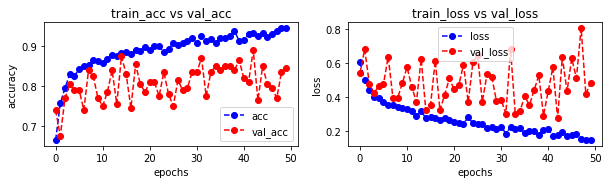

In [ ]:
plot_accuracy_loss(history)

## Evaluation

In [ ]:
# use validation data generatoronly since only rescaling is applied
test_generator = val_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size=1,
        class_mode='binary',
        shuffle=False)  # disable shuffling so predictions can be compared with ground truths

Found 200 images belonging to 2 classes.


In [ ]:
test_loss = model.evaluate(test_generator)

200/200 [==============================] - 3s 17ms/step - loss: 0.5298 - accuracy: 0.8550


In [ ]:
labels = test_generator.class_indices
labels

{'donkey': 0, 'horse': 1}

In [ ]:
y_test = test_generator.classes
y_pred = np.rint(model.predict(test_generator))

# print the first 5 predictions
y_pred[:5]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [ ]:
report = classification_report(y_test, y_pred, target_names=labels, output_dict=True)
df = pd.DataFrame(report)
df

,donkey,horse,accuracy,macro avg,weighted avg
precision,0.881720,0.831776,0.855,0.856748,0.856748
recall,0.820000,0.890000,0.855,0.855000,0.855000
f1-score,0.849741,0.859903,0.855,0.854822,0.854822
support,100.000000,100.000000,0.855,200.000000,200.000000


# Load model (only if there is a saved model)

In [5]:
model = keras.models.load_model(model_path)

# Prediction

While it is possible to pass genrator to model.predict(), the images cannot be output together. In order to show images with predictions, I will use another way to make predictions, and the two ways just generate the same results.

In [ ]:
# pred_datagen = ImageDataGenerator(rescale=1./255)

# pred_generator = pred_datagen.flow_from_directory(
#         pred_dir,
#         target_size=(224, 224),
#         batch_size=1,
#         classes=['images'],
#         class_mode=None,
#         shuffle=False)

In [ ]:
# predictions = np.rint(model.predict(pred_generator))
# predictions

In [7]:
data_list = []
pred_imgs = os.listdir(os.path.join(pred_dir, 'images'))

for f in pred_imgs:
  fpath = os.path.join (pred_dir, 'images', f)
  img = cv2.imread(fpath)
  img = cv2.resize(img, (224,224))
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  data_list.append(img)

data = np.array(data_list)/255
predictions = np.rint(model.predict(data))

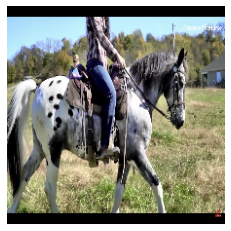

horse 



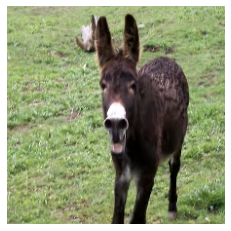

donkey 



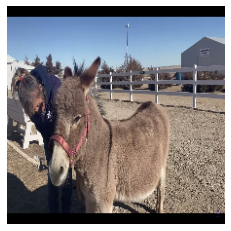

donkey 



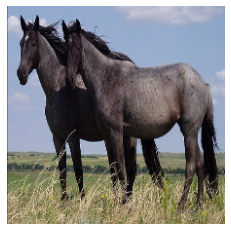

horse 



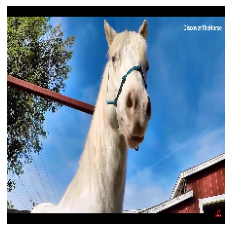

horse 



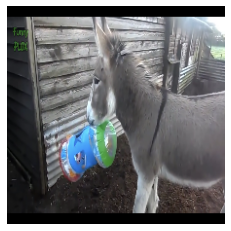

horse 



In [8]:
classes = ['donkey', 'horse']

for i in range(len(data_list)):
  plt.imshow(data_list[i])
  plt.axis('off')
  plt.show()

  print(classes[int(predictions[i])], '\n')